In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from fastai.vision.all import *
import sklearn

path = '/content/Dataset'
BATCH_SIZE = 64


In [ ]:
t_fnames = get_image_files(os.path.join(path, "Training"))
train_fnames, val_fnames = sklearn.model_selection.train_test_split(t_fnames, test_size=0.25)
test_fnames = get_image_files(os.path.join(path, "Testing"))
all_files = get_image_files(path)

train_idxs = [i for i, fname in enumerate(all_files) if fname in train_fnames]
val_idxs = [i for i, fname in enumerate(all_files) if fname in val_fnames]
test_idxs = [i for i, fname in enumerate(all_files) if fname in test_fnames]

print("train:", len(train_idxs))
print("val:", len(val_idxs))
print("test:", len(test_idxs))

train: 9320
val: 3107
test: 1381


mean: TensorImage([0.5394, 0.5394, 0.5394], device='cuda:0') , std: TensorImage([0.2336, 0.2336, 0.2336], device='cuda:0')


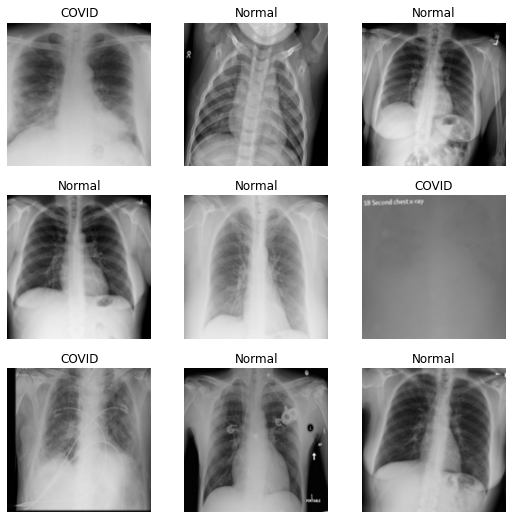

In [ ]:
augs = [RandomResizedCropGPU(size=256, min_scale=0.75), Rotate(), Zoom()]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=lambda x: [train_idxs, val_idxs],
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(all_files)
dls.show_batch()

means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
print("mean:", mean, ", std:", std)

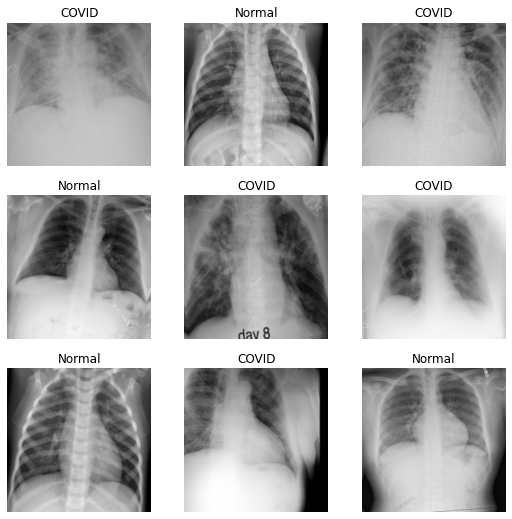

In [ ]:
augs = [RandomResizedCropGPU(size=360, min_scale=0.75), Rotate(), Zoom()]
augs += [Normalize.from_stats(mean, std)]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=lambda x: [train_idxs, val_idxs],
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls = dblock.dataloaders(all_files)
dls.show_batch()

SuggestedLRs(valley=0.001737800776027143)

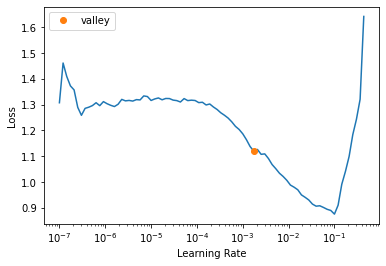

In [ ]:
metrics = [accuracy, F1Score(), Precision(), Recall()]
learn = cnn_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(),
                    metrics=metrics)

learn.lr_find()

In [ ]:
# learn.fit_one_cycle(5, slice(8e-4, 1e-2))
# learn.unfreeze()
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time


In [ ]:
import csv

f = open('/content/output.csv', 'w')
writer = csv.writer(f)
writer.writerow(["Filename", "Label"])

for i in range(1, 1382, BATCH_SIZE):
  test_fname_cur = [f"Dataset/Testing/{j}.png" for j in range(i, i+BATCH_SIZE) if j<1382]
  test_dl = dls.test_dl(test_fname_cur)

  pred = learn.get_preds(dl=test_dl)[0]

  c = 0
  for p in pred:
    if np.argmax(p) == 0:
      writer.writerow([i+c, "COVID"])
    else: 
      writer.writerow([i+c, "NORMAL"])
    c+=1

f.close()